In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [ ]:
import torch


Kiểm tra CUDA Toolkit

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Load local MNIST

In [2]:
mnist_folder = "./MNIST_Dataset"

LoadMNIST from https://stackoverflow.com/a/53226079

In [3]:
def loadMNIST(prefix, folder):
    
    data_path = "-images-idx3-ubyte"
    labels_path = "-labels-idx1-ubyte"

    intType = np.dtype('int32').newbyteorder('>')
    nMetaDataBytes = 4 * intType.itemsize
    
    data = np.fromfile(folder + "/" + prefix + data_path, dtype = 'ubyte')
    magicBytes, nImages, width, height = np.frombuffer( data[:nMetaDataBytes].tobytes(), intType)
    data = data[nMetaDataBytes:].astype( dtype='float32').reshape([nImages, width, height])
    
    labels = np.fromfile(folder + "/" + prefix + labels_path, dtype = 'ubyte')[2 * intType.itemsize:]
    
    return data, labels

In [30]:
trainingImages, trainingLabels = loadMNIST( "train", mnist_folder )
testImages, testLabels = loadMNIST( "t10k", mnist_folder )

__Test MNIST loader__

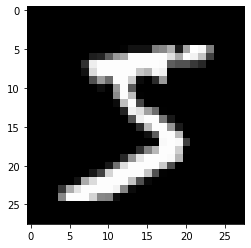

In [24]:
img1 = trainingImages[0]

img1_2d = np.reshape(img1, (28, 28))

plt.subplot(111)
plt.imshow(img1_2d, cmap=plt.get_cmap('gray'))
plt.show()

## 2. CNN Models
### 2.1. CNN Layers [6, 7, 9, 14,15]


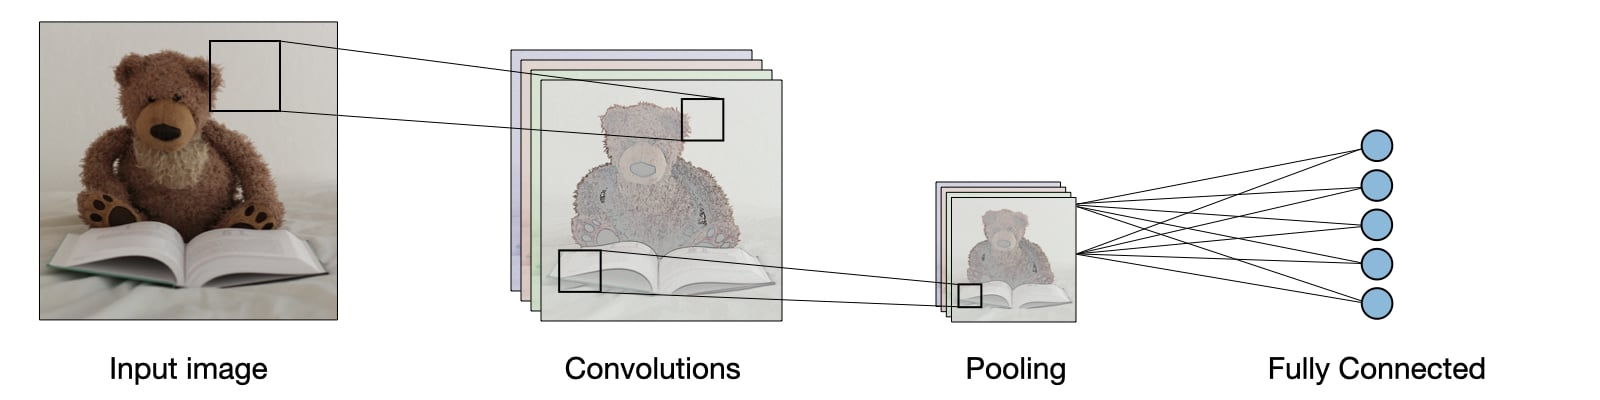
Source: [16]

#### a. Convolution layer [7, 9]
Simple convolution layer with: 
+ Filter: 3x3xN (N: num_filters)
+ Padding: "valid" or "same"

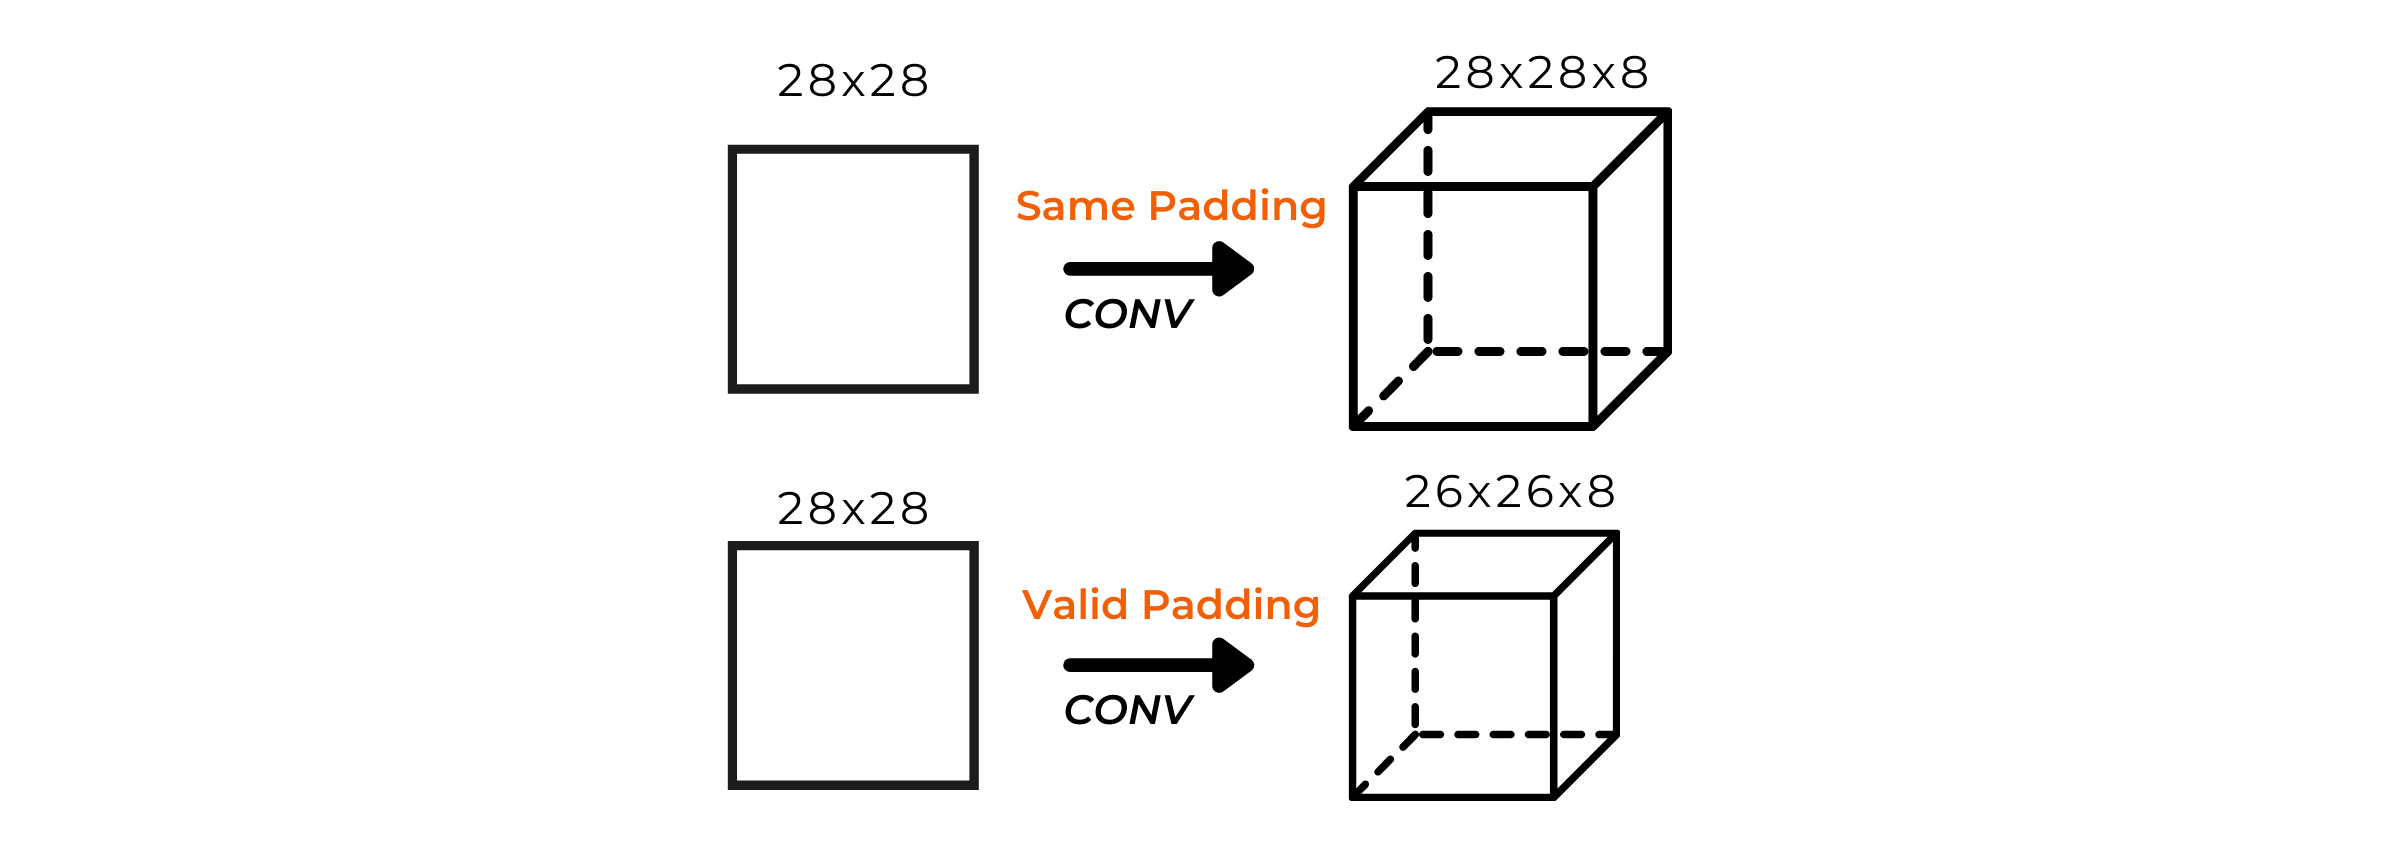

In [152]:
class Conv: 
    def __init__(
        self, 
        num_filters, 
        padding: str = "valid"
    ):
        self.num_filters = num_filters
        self.filters = np.random.randn(num_filters, 3, 3)/9
        self.padding = padding
    
    def iterate_regions(self, image):
        h, w =  image.shape
        
        #Same Padding
        if (self.padding == "same"):
            pad_image = np.pad(image, 1, mode='constant')
            for i in range(h):
                for j in range(w):
                    img_region = pad_image[i:(i+3), j:(j+3)]
                    yield img_region, i, j
                    
        #Valid Padding            
        elif (self.padding == "valid"):
            for i in range(h-2):
                for j in range(w-2):
                    img_region = image[i:(i+3), j:(j+3)]
                    yield img_region, i, j
        else:
            raise Exception(
                f"Unsupported padding value: {self.padding}"
            )
        
    def forward(self, input):
        self.last_input = input
        
        h, w = input.shape

        #Same Padding
        if (self.padding == "same"):
            output = np.zeros((h, w, self.num_filters))
                    
        #Valid Padding            
        elif (self.padding == "valid"):
            output = np.zeros((h-2, w-2, self.num_filters))

        else:
            raise Exception(
                f"Unsupported padding value: {self.padding}"
            )
                
        for img_region, i, j in self.iterate_regions(input):
            output[i, j] = np.sum(img_region * self.filters, axis=(1, 2))

        return output
    
    def backpropagation(self, dL_dout, learning_rate):
        dL_dfilters = np.zeros(self.filters.shape)
        
        for img_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                dL_dfilters[f] += dL_dout[i, j, f] * img_region
                
        self.filters -= learning_rate * dL_dfilters
        
        return None

##### #3 Backpropagation on Convolution layer [6, 12]: 
$$\frac{\partial L}{\partial filter(x, y)} = \sum_{i}\sum _{j}\frac{\partial L}{\partial out(i, j)} * \frac{\partial out(i, j)}{\partial filter(x, y)}$$

#### b. MaxPooling Layer with 2x2 windows


In [6]:
class MaxPool:
    def iterate_region(self, image):
        h, w, _ = image.shape
        h_new = h // 2
        w_new = w // 2
        
        for i in range(h_new):
            for j in range(w_new):
                img_region = image[(i*2):(i*2+2), (j*2):(j*2+2)]
                yield img_region, i, j
    
    def forward(self, input):
        self.last_input = input
        h, w, num_filters = input.shape
        
        pool_output = np.zeros((h//2, w//2, num_filters))
        for img_region, i, j in self.iterate_region(input):
            pool_output[i, j] = np.amax(img_region, axis=(0, 1))
        return pool_output
    
    def backpropagation(self, dL_dout):
        dL_dinput = np.zeros(self.last_input.shape)

        for img_region, j, j in self.iterate_region(self.last_input):
            #shape of convolution layer's output
            h, w, f = img_region.shape
            #get max_pool
            amax = np.amax(img_region, axis=(0, 1))
            for ih in range(h):
                for jw in range(w):
                    for f2 in range(f):
                        if(img_region[ih,jw,f2] == amax[f2]):
                            #Check if (i*2+ih, j*2+jw ,f2) in range
                            if((i*2+ih < h) and (j*2+jw < w)):
                                dL_dinput[i*2+ih, j*2+jw ,f2] = dL_dout[i, j, f2]
        return dL_dinput

##### #2 Backpropagation on Max Pooling layer [6] with 2x2 window: 
+ $\frac{\partial L}{\partial input} = 0$ for non-max pixels
+ $\frac{\partial L}{\partial input}  = \frac{\partial L}{\partial output}$ for max-value pixels

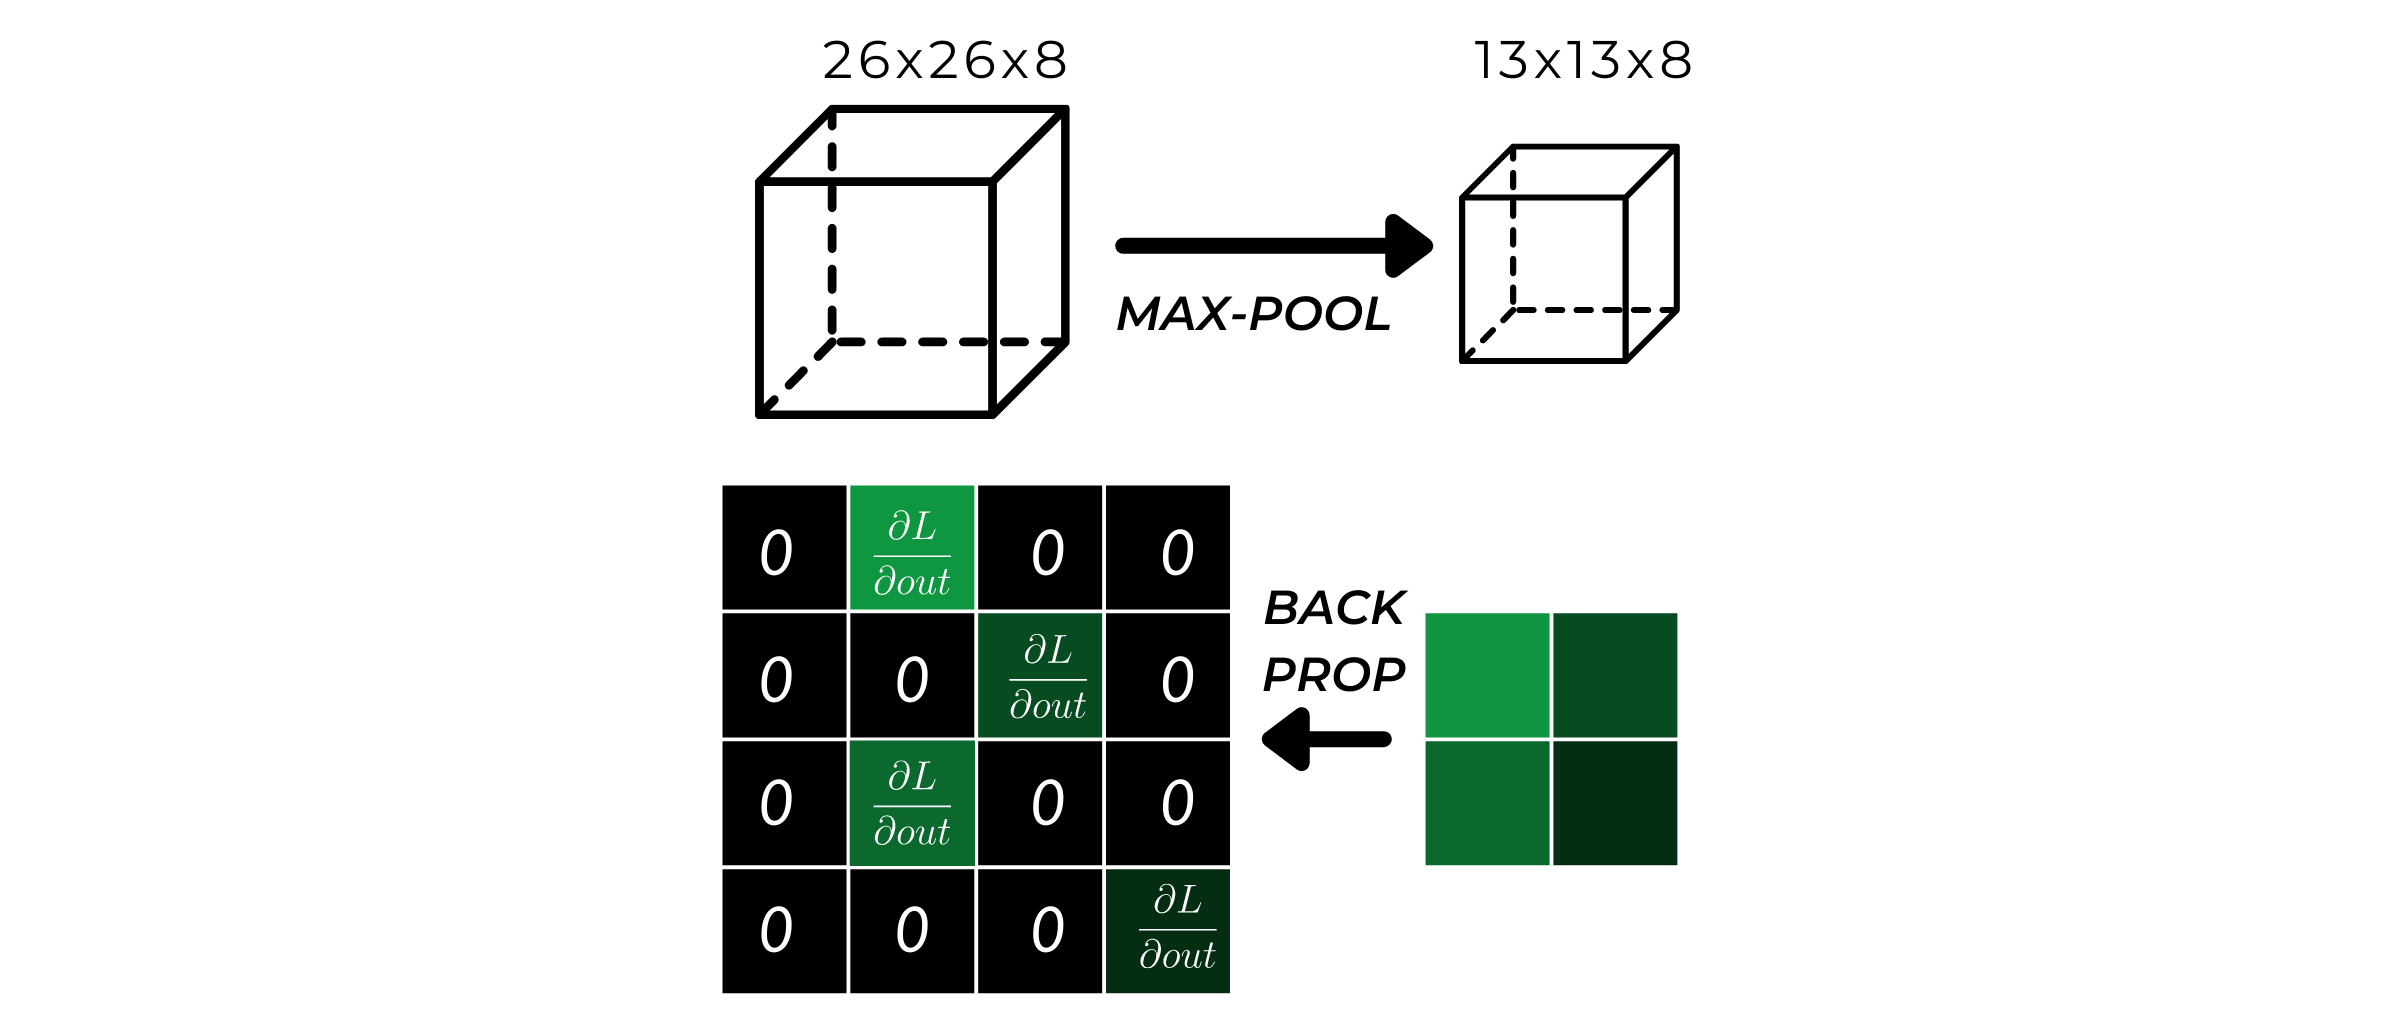

#### c. Softmax Layer
__Softmax function:__ $$f_i(x) = \frac{e^{x_i}}{\sum_{j}e^{x_j}}$$, with $x \in \{0, 9\}$


In [7]:
class Softmax:
    def __init__(self, input_len, nodes):
        self.weights = np.random.randn(input_len, nodes)/input_len
        self.bias = np.zeros(nodes)
        
    def forward(self, input):
        #Input shape before Flatten
        self.last_input_shape = input.shape
        
        #Flatten Max-Pooling output
        input = input.flatten()
        self.last_input = input
        
        input_len, nodes = self.weights.shape
        
        #Fully Connected
        totals = np.dot(input, self.weights) + self.bias
        self.last_totals = totals
        
        exp = np.exp(totals)
        return (exp/np.sum(exp, axis = 0))
    
    def backpropagation(self, dL_dout, learning_rate):
        for i, gradient in enumerate(dL_dout):
            #dL_dout = gradient
            if gradient == 0:
                continue
            
            #e^total
            t_exp = np.exp(self.last_totals)
            
            #Sum of e^total, denominator of Softmax function
            S = np.sum(t_exp)
            
            #Gradients of out[i] against totals
            dout_dt = -t_exp[i] * t_exp / (S**2)
            # - with i = c, update dout_dt[i]
            dout_dt[i] = t_exp[i] * (S-t_exp[i]) / (S**2)
            
            #Gradient of total against weights/bias/inputs
            dt_dw = self.last_input
            dt_db = 1
            dt_dinputs = self.weights
            
            #Gradients of loss against totals
            #dL_dt = dL_dout a.k.a gradient * dout_dt
            dL_dt = gradient * dout_dt
            
            #Gradients of loss against weights/biases/input
            # + [Vector] dt_dw.Transform x [Vector] dL_dt
            # + Dimension dL_dw: (input_len, 1) x (1, nodes) 
            dL_dw = dt_dw[np.newaxis].T @ dL_dt[np.newaxis]
            dL_db = dL_dt * dt_db
            # + Dimension dL_dinputs: (input_len, nodes) x (nodes, 1)
            dL_dinputs = dt_dinputs @ dL_dt
            
            self.weights -= learning_rate * dL_dw
            self.bias -= learning_rate * dL_db
        
        # return gradient dL_dinputs with shape from the previous layer's output
        return dL_dinputs.reshape(self.last_input_shape)

##### #1 Backpropagation on Softmax [6, 10, 11]: 
__Gradients of Cross-entropy loss against Softmax layer's input:__
$$\frac{\partial L}{\partial input} = \frac{\partial L}{\partial out} * \frac{\partial out}{\partial t} * \frac{\partial t}{\partial input}$$
Trong đó: 
+ Gradients of totals against input: $$\frac{\partial t}{\partial input} = \frac{\partial (w*input +b)}{\partial input} = w$$
+ Gradients of $out_i$ against _totals_ $S$: $$\frac{\partial out_s(i)}{\partial t} = \begin{cases}
 \frac{-e^{t_c}e^{t_i}}{S^2} & \text{ if } i\neq c\\
 -\frac{e^{t_c}(S-e^{t_c})}{S^2}& \text{ if } i = c 
\end{cases}$$ 
+ Gradients of Cross-entropy loss for this layer's outputs: $$\frac{\partial L}{\partial out} = \begin{cases}
 0 & \text{ if } i\neq c\\
 -\frac{1}{p_i}& \text{ if } i = c 
\end{cases}$$ 



__Gradients of Cross-entropy loss against weights:__
$$\frac{\partial L}{\partial w} = \frac{\partial L}{\partial out} * \frac{\partial out}{\partial t} * \frac{\partial t}{\partial w}$$
__Gradients of Cross-entropy loss against bias:__
$$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial out} * \frac{\partial out}{\partial t} * \frac{\partial t}{\partial b}$$


### 2.2 Some CNN Models
#### Utilities

In [9]:
def history_chart(data, title, xlabel, ylabel, legend):
    plt.plot(data)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend([legend], loc='upper left')
    plt.show()
    return plt

#### a. CNN models without non-linear activation layer
##### Shallow CNN -with Conv(same padding)

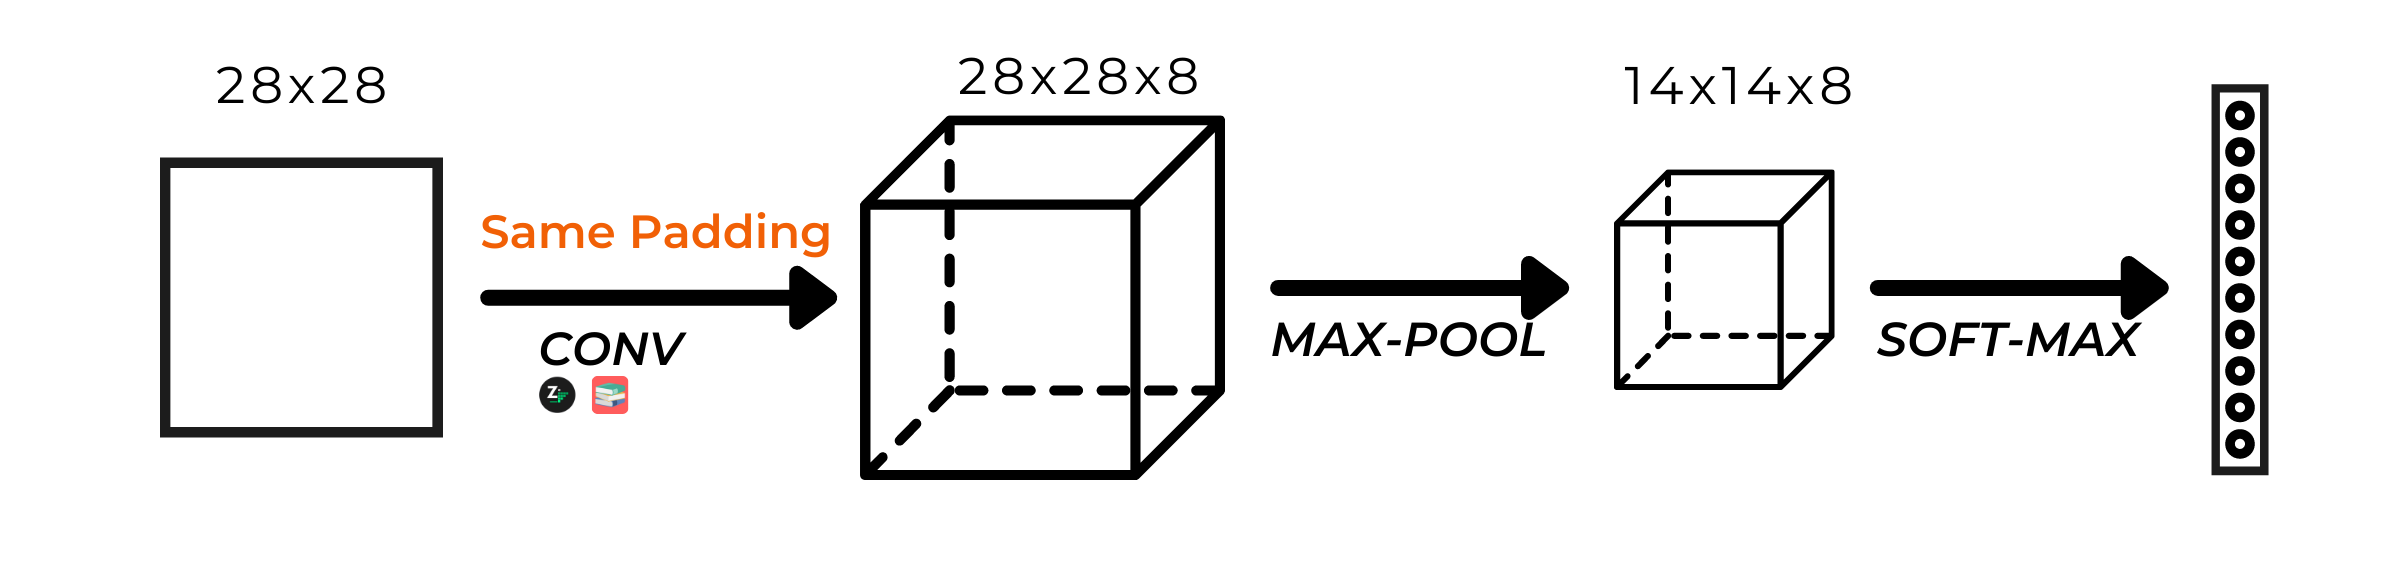

In [49]:
SCNN_conv = Conv(8, "same")
SCNN_pool = MaxPool()
SCNN_softmax = Softmax(14*14*8, 10)

def forward(image, label):
    
    out = SCNN_conv.forward((image/255) - 0.5)    
    out = SCNN_pool.forward(out)
    out = SCNN_softmax.forward(out)

    loss = -np.log(out[label])
    acc = 1 if(np.argmax(out) == label) else 0
    
    return out, loss, acc

def train(img, label, lr=0.05):
    out, loss, acc = forward(img, label)
    
    gradient = np.zeros(10)
    gradient[label] = -1/out[label]
    
    gradient = SCNN_softmax.backpropagation(gradient, lr)
    gradient = SCNN_pool.backpropagation(gradient)
    gradient = SCNN_conv.backpropagation(gradient, lr)
    
    return loss, acc

In [50]:
SCNN_history = {'loss': [], 'accuracy': []}

__Training process of Shallow CNN on MNIST__

In [51]:
print('MNIST Shallow CNN initialized')

SCNN_train_Images = trainingImages
SCNN_train_Labels = trainingLabels

for epoch in range(1):
    print('----EPOCH %d ---'%(epoch+1))

    #shuffle the training data
    permutation = np.random.permutation(len(SCNN_train_Images))
    SCNN_train_Images = SCNN_train_Images[permutation]
    SCNN_train_Labels = SCNN_train_Labels[permutation]


    loss = 0
    num_correct = 0

    for i, (im, label) in enumerate(zip(SCNN_train_Images, SCNN_train_Labels)):

        #print stats every 100 steps
        if(i>0 and i % 100 == 99):
            print('[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %(i + 1, loss / 100, num_correct))
            
            SCNN_history['loss'].append(loss/100)
            SCNN_history['accuracy'].append(num_correct/100)
            
            loss = 0
            num_correct = 0
        l, acc = train(im, label)
        loss += l
        num_correct += acc

MNIST Shallow CNN initialized
----EPOCH 1 ---
[Step 100] Past 100 steps: Average Loss 1.924 | Accuracy: 35%
[Step 200] Past 100 steps: Average Loss 1.291 | Accuracy: 58%
[Step 300] Past 100 steps: Average Loss 0.969 | Accuracy: 71%
[Step 400] Past 100 steps: Average Loss 1.008 | Accuracy: 69%
[Step 500] Past 100 steps: Average Loss 0.652 | Accuracy: 80%
[Step 600] Past 100 steps: Average Loss 0.627 | Accuracy: 77%
[Step 700] Past 100 steps: Average Loss 0.588 | Accuracy: 79%
[Step 800] Past 100 steps: Average Loss 0.831 | Accuracy: 71%
[Step 900] Past 100 steps: Average Loss 0.728 | Accuracy: 73%
[Step 1000] Past 100 steps: Average Loss 0.466 | Accuracy: 83%
[Step 1100] Past 100 steps: Average Loss 0.477 | Accuracy: 85%
[Step 1200] Past 100 steps: Average Loss 0.636 | Accuracy: 77%
[Step 1300] Past 100 steps: Average Loss 0.538 | Accuracy: 82%
[Step 1400] Past 100 steps: Average Loss 0.341 | Accuracy: 90%
[Step 1500] Past 100 steps: Average Loss 0.559 | Accuracy: 82%
[Step 1600] Past 1

[Step 13000] Past 100 steps: Average Loss 0.504 | Accuracy: 89%
[Step 13100] Past 100 steps: Average Loss 0.244 | Accuracy: 93%
[Step 13200] Past 100 steps: Average Loss 0.542 | Accuracy: 87%
[Step 13300] Past 100 steps: Average Loss 0.427 | Accuracy: 87%
[Step 13400] Past 100 steps: Average Loss 0.414 | Accuracy: 85%
[Step 13500] Past 100 steps: Average Loss 0.428 | Accuracy: 90%
[Step 13600] Past 100 steps: Average Loss 0.430 | Accuracy: 85%
[Step 13700] Past 100 steps: Average Loss 0.276 | Accuracy: 92%
[Step 13800] Past 100 steps: Average Loss 0.335 | Accuracy: 90%
[Step 13900] Past 100 steps: Average Loss 0.205 | Accuracy: 93%
[Step 14000] Past 100 steps: Average Loss 0.361 | Accuracy: 85%
[Step 14100] Past 100 steps: Average Loss 0.440 | Accuracy: 89%
[Step 14200] Past 100 steps: Average Loss 0.473 | Accuracy: 85%
[Step 14300] Past 100 steps: Average Loss 0.168 | Accuracy: 94%
[Step 14400] Past 100 steps: Average Loss 0.327 | Accuracy: 92%
[Step 14500] Past 100 steps: Average Los

[Step 25900] Past 100 steps: Average Loss 0.327 | Accuracy: 88%
[Step 26000] Past 100 steps: Average Loss 0.288 | Accuracy: 92%
[Step 26100] Past 100 steps: Average Loss 0.291 | Accuracy: 88%
[Step 26200] Past 100 steps: Average Loss 0.390 | Accuracy: 89%
[Step 26300] Past 100 steps: Average Loss 0.255 | Accuracy: 90%
[Step 26400] Past 100 steps: Average Loss 0.401 | Accuracy: 88%
[Step 26500] Past 100 steps: Average Loss 0.149 | Accuracy: 96%
[Step 26600] Past 100 steps: Average Loss 0.433 | Accuracy: 88%
[Step 26700] Past 100 steps: Average Loss 0.276 | Accuracy: 90%
[Step 26800] Past 100 steps: Average Loss 0.280 | Accuracy: 92%
[Step 26900] Past 100 steps: Average Loss 0.405 | Accuracy: 88%
[Step 27000] Past 100 steps: Average Loss 0.153 | Accuracy: 96%
[Step 27100] Past 100 steps: Average Loss 0.360 | Accuracy: 92%
[Step 27200] Past 100 steps: Average Loss 0.313 | Accuracy: 91%
[Step 27300] Past 100 steps: Average Loss 0.517 | Accuracy: 87%
[Step 27400] Past 100 steps: Average Los

[Step 38800] Past 100 steps: Average Loss 0.262 | Accuracy: 94%
[Step 38900] Past 100 steps: Average Loss 0.254 | Accuracy: 92%
[Step 39000] Past 100 steps: Average Loss 0.259 | Accuracy: 93%
[Step 39100] Past 100 steps: Average Loss 0.351 | Accuracy: 89%
[Step 39200] Past 100 steps: Average Loss 0.218 | Accuracy: 95%
[Step 39300] Past 100 steps: Average Loss 0.182 | Accuracy: 95%
[Step 39400] Past 100 steps: Average Loss 0.412 | Accuracy: 89%
[Step 39500] Past 100 steps: Average Loss 0.193 | Accuracy: 97%
[Step 39600] Past 100 steps: Average Loss 0.391 | Accuracy: 93%
[Step 39700] Past 100 steps: Average Loss 0.216 | Accuracy: 92%
[Step 39800] Past 100 steps: Average Loss 0.370 | Accuracy: 86%
[Step 39900] Past 100 steps: Average Loss 0.221 | Accuracy: 93%
[Step 40000] Past 100 steps: Average Loss 0.183 | Accuracy: 96%
[Step 40100] Past 100 steps: Average Loss 0.168 | Accuracy: 96%
[Step 40200] Past 100 steps: Average Loss 0.360 | Accuracy: 90%
[Step 40300] Past 100 steps: Average Los

[Step 51700] Past 100 steps: Average Loss 0.369 | Accuracy: 92%
[Step 51800] Past 100 steps: Average Loss 0.160 | Accuracy: 96%
[Step 51900] Past 100 steps: Average Loss 0.173 | Accuracy: 95%
[Step 52000] Past 100 steps: Average Loss 0.164 | Accuracy: 92%
[Step 52100] Past 100 steps: Average Loss 0.404 | Accuracy: 87%
[Step 52200] Past 100 steps: Average Loss 0.266 | Accuracy: 93%
[Step 52300] Past 100 steps: Average Loss 0.171 | Accuracy: 95%
[Step 52400] Past 100 steps: Average Loss 0.191 | Accuracy: 92%
[Step 52500] Past 100 steps: Average Loss 0.238 | Accuracy: 91%
[Step 52600] Past 100 steps: Average Loss 0.176 | Accuracy: 93%
[Step 52700] Past 100 steps: Average Loss 0.214 | Accuracy: 92%
[Step 52800] Past 100 steps: Average Loss 0.280 | Accuracy: 89%
[Step 52900] Past 100 steps: Average Loss 0.351 | Accuracy: 91%
[Step 53000] Past 100 steps: Average Loss 0.115 | Accuracy: 99%
[Step 53100] Past 100 steps: Average Loss 0.248 | Accuracy: 91%
[Step 53200] Past 100 steps: Average Los

Loss curve of training SCNN model

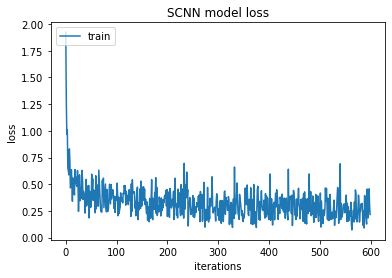

In [53]:
SCNN_loss_curve = history_chart(SCNN_history['loss'], 'SCNN model loss', 'iterations', 'loss', 'train')

Accuracy curve of training SCNN model

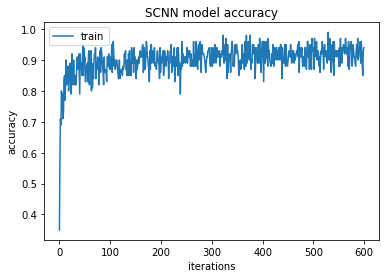

In [54]:
SCNN_acc_curve = history_chart(SCNN_history['accuracy'], 'SCNN model accuracy', 'iterations', 'accuracy', 'train')

Test Shallow CNN model

In [56]:
SCNN_test = {'loss': 0, 'accuracy': 0}

In [57]:
print('\n--- Testing the Shallow CNN ---')
loss = 0
num_correct = 0

for im, label in zip(testImages, testLabels):
  _, l, acc = forward(im, label)
  loss += l
  num_correct += acc

num_tests = len(testImages)

print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)

SCNN_test['loss'] += loss / num_tests
SCNN_test['accuracy'] += num_correct / num_tests


--- Testing the Shallow CNN ---
Test Loss: 0.24728568333102804
Test Accuracy: 0.9269


__Challenge of this approach: CNN model with 2 of more hidden Convolution layers__


#### b. CNN models with non-linear activation function

##### ReLU Activation 
$$ReLU(x) = max(0, x)$$

In [153]:
class ReLU: 
    def __init__(self):
        self.cache = None
        
    def forward(self, input):
        self.cache = np.maximum(0, input)
        return self.cache
    
    def backpropagation(self, dL_dout):
        dL_dinput = np.array(dL_dout, copy = True)
        dL_dinput[self.cache <= 0] = 0
        return dL_dinput

Backpropagation of ReLU
$$\frac{\partial ReLU}{\partial x} = \begin{cases}
 1 & \text{ if } x > 0\\
 0 & \text{ ortherwise } 
\end{cases}$$ 

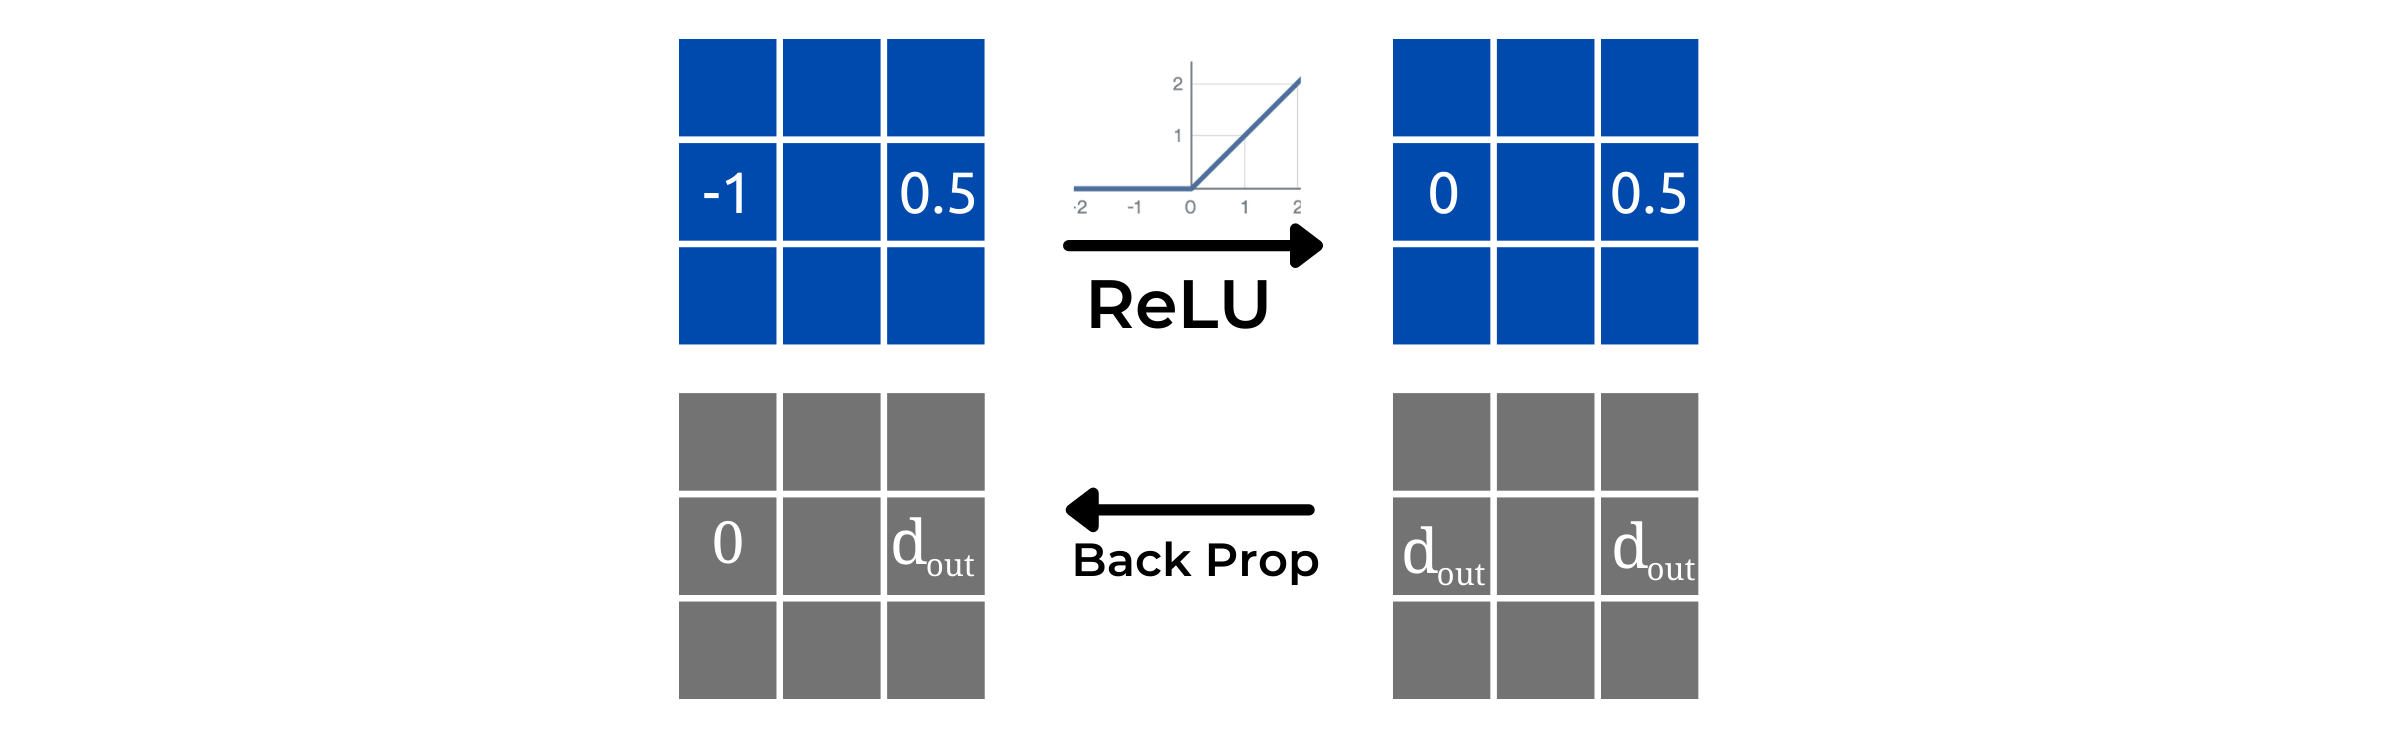

##### ReCNN Model: with Conv(same padding) & ReLU activation

In [156]:
ReCNN_conv = Conv(8, "same")
ReCNN_relu = ReLU()
ReCNN_pool = MaxPool()
ReCNN_softmax = Softmax(14*14*8, 10)

def ReCNNforward(image, label):
    
    out = ReCNN_conv.forward((image/255) - 0.5) 
    out = ReCNN_relu.forward(out)
    out = ReCNN_pool.forward(out)
    out = ReCNN_softmax.forward(out)

    loss = -np.log(out[label])
    acc = 1 if(np.argmax(out) == label) else 0
    
    return out, loss, acc

def ReCNNtrain(img, label, lr=0.05):
    out, loss, acc = ReCNNforward(img, label)
    
    gradient = np.zeros(10)
    gradient[label] = -1/out[label]
    
    gradient = ReCNN_softmax.backpropagation(gradient, lr)
    gradient = ReCNN_pool.backpropagation(gradient)
    gradient = ReCNN_relu.backpropagation(gradient)
    gradient = ReCNN_conv.backpropagation(gradient, lr)
    
    return loss, acc

In [157]:
ReCNN_history = {'loss': [], 'accuracy': []}

In [158]:
print('MNIST CNN with ReLU activation initialized')

ReCNN_train_Images = trainingImages
ReCNN_train_Labels = trainingLabels

for epoch in range(1):
    print('----EPOCH %d ---'%(epoch+1))

    #shuffle the training data
    permutation = np.random.permutation(len(ReCNN_train_Images))
    ReCNN_train_Images = ReCNN_train_Images[permutation]
    ReCNN_train_Labels = ReCNN_train_Labels[permutation]


    loss = 0
    num_correct = 0

    for i, (im, label) in enumerate(zip(ReCNN_train_Images, ReCNN_train_Labels)):

        #print stats every 100 steps
        if(i>0 and i % 100 == 99):
            print('[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %(i + 1, loss / 100, num_correct))
            
            ReCNN_history['loss'].append(loss/100)
            ReCNN_history['accuracy'].append(num_correct/100)
            
            loss = 0
            num_correct = 0
        l, acc = ReCNNtrain(im, label)
        loss += l
        num_correct += acc

MNIST CNN with ReLU activation initialized
----EPOCH 1 ---
[Step 100] Past 100 steps: Average Loss 2.411 | Accuracy: 14%
[Step 200] Past 100 steps: Average Loss 2.050 | Accuracy: 22%
[Step 300] Past 100 steps: Average Loss 1.688 | Accuracy: 39%
[Step 400] Past 100 steps: Average Loss 1.397 | Accuracy: 55%
[Step 500] Past 100 steps: Average Loss 1.357 | Accuracy: 49%
[Step 600] Past 100 steps: Average Loss 1.225 | Accuracy: 63%
[Step 700] Past 100 steps: Average Loss 1.213 | Accuracy: 63%
[Step 800] Past 100 steps: Average Loss 1.013 | Accuracy: 66%
[Step 900] Past 100 steps: Average Loss 0.968 | Accuracy: 66%
[Step 1000] Past 100 steps: Average Loss 0.892 | Accuracy: 76%
[Step 1100] Past 100 steps: Average Loss 0.983 | Accuracy: 71%
[Step 1200] Past 100 steps: Average Loss 0.852 | Accuracy: 78%
[Step 1300] Past 100 steps: Average Loss 0.866 | Accuracy: 76%
[Step 1400] Past 100 steps: Average Loss 0.814 | Accuracy: 71%
[Step 1500] Past 100 steps: Average Loss 0.603 | Accuracy: 79%
[Step

[Step 13000] Past 100 steps: Average Loss 0.289 | Accuracy: 91%
[Step 13100] Past 100 steps: Average Loss 0.307 | Accuracy: 89%
[Step 13200] Past 100 steps: Average Loss 0.485 | Accuracy: 85%
[Step 13300] Past 100 steps: Average Loss 0.260 | Accuracy: 92%
[Step 13400] Past 100 steps: Average Loss 0.265 | Accuracy: 90%
[Step 13500] Past 100 steps: Average Loss 0.410 | Accuracy: 89%
[Step 13600] Past 100 steps: Average Loss 0.600 | Accuracy: 80%
[Step 13700] Past 100 steps: Average Loss 0.504 | Accuracy: 87%
[Step 13800] Past 100 steps: Average Loss 0.385 | Accuracy: 88%
[Step 13900] Past 100 steps: Average Loss 0.457 | Accuracy: 86%
[Step 14000] Past 100 steps: Average Loss 0.370 | Accuracy: 89%
[Step 14100] Past 100 steps: Average Loss 0.232 | Accuracy: 95%
[Step 14200] Past 100 steps: Average Loss 0.376 | Accuracy: 90%
[Step 14300] Past 100 steps: Average Loss 0.296 | Accuracy: 90%
[Step 14400] Past 100 steps: Average Loss 0.398 | Accuracy: 90%
[Step 14500] Past 100 steps: Average Los

[Step 25900] Past 100 steps: Average Loss 0.297 | Accuracy: 88%
[Step 26000] Past 100 steps: Average Loss 0.306 | Accuracy: 91%
[Step 26100] Past 100 steps: Average Loss 0.305 | Accuracy: 91%
[Step 26200] Past 100 steps: Average Loss 0.369 | Accuracy: 90%
[Step 26300] Past 100 steps: Average Loss 0.216 | Accuracy: 94%
[Step 26400] Past 100 steps: Average Loss 0.165 | Accuracy: 96%
[Step 26500] Past 100 steps: Average Loss 0.345 | Accuracy: 90%
[Step 26600] Past 100 steps: Average Loss 0.371 | Accuracy: 89%
[Step 26700] Past 100 steps: Average Loss 0.219 | Accuracy: 92%
[Step 26800] Past 100 steps: Average Loss 0.369 | Accuracy: 90%
[Step 26900] Past 100 steps: Average Loss 0.346 | Accuracy: 90%
[Step 27000] Past 100 steps: Average Loss 0.259 | Accuracy: 92%
[Step 27100] Past 100 steps: Average Loss 0.307 | Accuracy: 94%
[Step 27200] Past 100 steps: Average Loss 0.328 | Accuracy: 86%
[Step 27300] Past 100 steps: Average Loss 0.290 | Accuracy: 91%
[Step 27400] Past 100 steps: Average Los

[Step 38800] Past 100 steps: Average Loss 0.222 | Accuracy: 95%
[Step 38900] Past 100 steps: Average Loss 0.327 | Accuracy: 84%
[Step 39000] Past 100 steps: Average Loss 0.224 | Accuracy: 90%
[Step 39100] Past 100 steps: Average Loss 0.454 | Accuracy: 83%
[Step 39200] Past 100 steps: Average Loss 0.218 | Accuracy: 91%
[Step 39300] Past 100 steps: Average Loss 0.142 | Accuracy: 96%
[Step 39400] Past 100 steps: Average Loss 0.505 | Accuracy: 87%
[Step 39500] Past 100 steps: Average Loss 0.354 | Accuracy: 86%
[Step 39600] Past 100 steps: Average Loss 0.301 | Accuracy: 90%
[Step 39700] Past 100 steps: Average Loss 0.334 | Accuracy: 91%
[Step 39800] Past 100 steps: Average Loss 0.264 | Accuracy: 92%
[Step 39900] Past 100 steps: Average Loss 0.527 | Accuracy: 86%
[Step 40000] Past 100 steps: Average Loss 0.293 | Accuracy: 91%
[Step 40100] Past 100 steps: Average Loss 0.261 | Accuracy: 93%
[Step 40200] Past 100 steps: Average Loss 0.270 | Accuracy: 91%
[Step 40300] Past 100 steps: Average Los

[Step 51700] Past 100 steps: Average Loss 0.248 | Accuracy: 93%
[Step 51800] Past 100 steps: Average Loss 0.219 | Accuracy: 92%
[Step 51900] Past 100 steps: Average Loss 0.337 | Accuracy: 92%
[Step 52000] Past 100 steps: Average Loss 0.367 | Accuracy: 87%
[Step 52100] Past 100 steps: Average Loss 0.306 | Accuracy: 92%
[Step 52200] Past 100 steps: Average Loss 0.250 | Accuracy: 93%
[Step 52300] Past 100 steps: Average Loss 0.166 | Accuracy: 94%
[Step 52400] Past 100 steps: Average Loss 0.210 | Accuracy: 94%
[Step 52500] Past 100 steps: Average Loss 0.310 | Accuracy: 91%
[Step 52600] Past 100 steps: Average Loss 0.402 | Accuracy: 87%
[Step 52700] Past 100 steps: Average Loss 0.145 | Accuracy: 96%
[Step 52800] Past 100 steps: Average Loss 0.196 | Accuracy: 93%
[Step 52900] Past 100 steps: Average Loss 0.368 | Accuracy: 91%
[Step 53000] Past 100 steps: Average Loss 0.262 | Accuracy: 90%
[Step 53100] Past 100 steps: Average Loss 0.106 | Accuracy: 98%
[Step 53200] Past 100 steps: Average Los

Loss curve of training ReCNN model

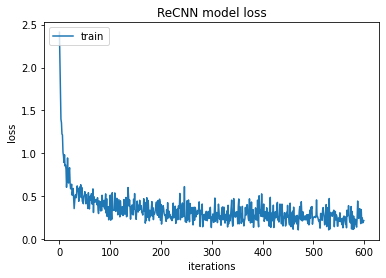

In [159]:
ReCNN_loss_curve = history_chart(ReCNN_history['loss'], 'ReCNN model loss', 'iterations', 'loss', 'train')

Accuracy curve of training ReCNN model

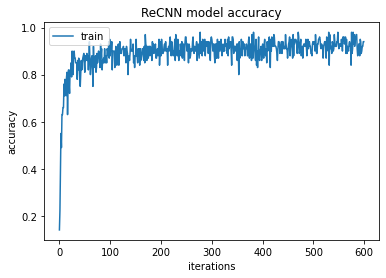

In [160]:
ReCNN_acc_curve = history_chart(ReCNN_history['accuracy'], 'ReCNN model accuracy', 'iterations', 'accuracy', 'train')

Test Shallow CNN model

In [161]:
ReCNN_test = {'loss': 0, 'accuracy': 0}

In [162]:
print('\n--- Testing the ReCNN Model: CNN with ReLU---')
loss = 0
num_correct = 0

for im, label in zip(testImages, testLabels):
  _, l, acc = ReCNNforward(im, label)
  loss += l
  num_correct += acc

num_tests = len(testImages)

print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)

ReCNN_test['loss'] += loss / num_tests
ReCNN_test['accuracy'] += num_correct / num_tests


--- Testing the ReCNN Model: CNN with ReLU---
Test Loss: 0.2320261187708437
Test Accuracy: 0.9309


## 3. CNN with Residual

In [43]:
testLabels.shape[0]

10000

In [33]:
trainingImages[:10000].shape

(10000, 28, 28)

# Reference
1. Goodfellow, I., Bengio, Y., & Courville, A. (2016). __Deep learning__. MIT press.
2. Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, november 1998. URL: http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf
3. __Numpy CNN__, URL: https://github.com/SkalskiP/ILearnDeepLearning.py/tree/master/01_mysteries_of_neural_networks/06_numpy_convolutional_neural_net
4. Ahmed Gad, __Building Convolutional Neural Network using NumPy from Scratch__, URL: https://towardsdatascience.com/building-convolutional-neural-network-using-numpy-from-scratch-b30aac50e50a
5. Chi-Feng Wang, __The Vanishing Gradient Problem__, URL: https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484
6. Victor Zhou, __CNNs, Part 1: An Introduction to Convolutional Neural Networks__, URL: https://victorzhou.com/blog/intro-to-cnns-part-1/
7. Victor Zhou, __CNNs, Part 2: Training a Convolutional Neural Network__, URL: https://victorzhou.com/blog/intro-to-cnns-part-2/
8. Mehrdad Yazdani, __What is an intuitive explanation of the Xavier Initialization for Deep Neural Networks?__ Quora, URL: https://qr.ae/pGVZY4
9. Piotr Skalski, __Let’s Code Convolutional Neural Network in plain NumPy__, URL: https://towardsdatascience.com/lets-code-convolutional-neural-network-in-plain-numpy-ce48e732f5d5
10. __Convolutional Neural Networks (CNN): Softmax & Cross-Entropy__, SuperDataScience, URL: https://www.superdatascience.com/blogs/convolutional-neural-networks-cnn-softmax-crossentropy
11. Raúl Gómez, __Understanding Categorical Cross-Entropy Loss, Binary Cross-Entropy Loss, Softmax Loss, Logistic Loss, Focal Loss and all those confusing names__, May 23, 2018, URL: https://gombru.github.io/2018/05/23/cross_entropy_loss/
12. Matt Mazur, __A Step by Step Backpropagation Example__, URL https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
13. milan, "CNN from scratch(numpy)", Kaggle, URL: https://www.kaggle.com/milan400/cnn-from-scratch-numpy/notebook
14. lpraat, __numpyCNN__, Github, URL: https://github.com/lpraat/numpyCNN
15. Piotr Skalski, __ILearnDeepLearning.py__, Github, URL: https://github.com/SkalskiP/ILearnDeepLearning.py/tree/master/01_mysteries_of_neural_networks/06_numpy_convolutional_neural_net
16. Afshine Amidi and Shervine Amidi, __Convolutional Neural Networks cheatsheet__, CS230 Stanford, URL: https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks
17. __Convolutional Neural Networks (CNNs / ConvNets)__, CS231n Stanford, URL: https://cs231n.github.io/convolutional-networks/
18. Prakash Jay, __Back-Propagation is very simple. Who made it Complicated ?__, URL: https://medium.com/@14prakash/back-propagation-is-very-simple-who-made-it-complicated-97b794c97e5c